# Color grading with optimal transport

#### *Nicolas Courty, Rémi Flamary*

In this tutorial we will learn how to perform color grading of images with optimal transport. This is somehow a very direct usage of optimal transport. You will learn how to treat an image as an empirical distribution, and apply optimal transport to find a matching between two different images seens as distributions. 

First we need to load two images. To this end we need some packages


In [1]:
import numpy as np
import matplotlib.pylab as pl
from matplotlib.pyplot import imread
from mpl_toolkits.mplot3d import Axes3D

I1 = imread('./data/klimt.jpg').astype(np.float64) / 256
I2 = imread('./data/schiele.jpg').astype(np.float64) / 256

We need some code to visualize them

In [2]:
def showImage(I,myPreferredFigsize=(8,8)):
    pl.figure(figsize=myPreferredFigsize)
    pl.imshow(I)
    pl.axis('off')
    pl.tight_layout()
    pl.show()

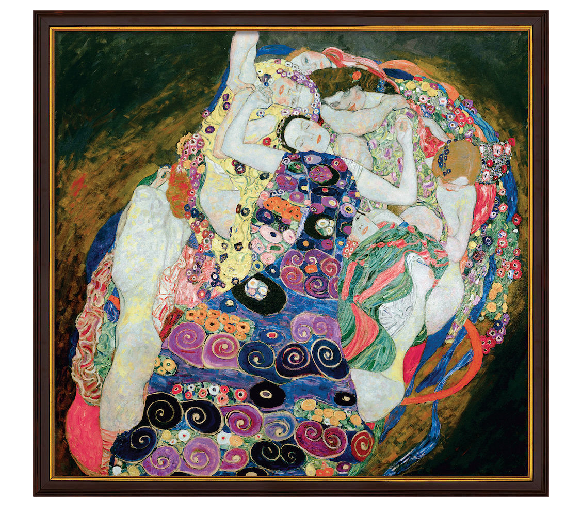

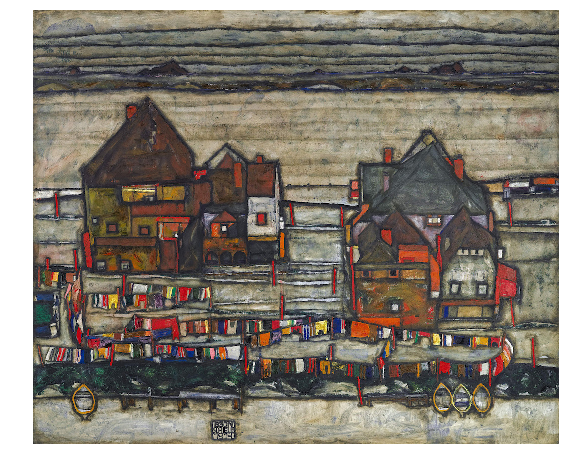

In [3]:
showImage(I1)
showImage(I2)

Those are two beautiful paintings of respectively Gustav Klimt and Egon Schiele. Now we will treat them as empirical distributions.

Write two functions that will be used to convert 2D images as arrays of 3D points (in the color space), and back.

In [4]:
def im2mat(I):
    """Converts and image to matrix (one pixel per line)"""
    return I.reshape((I.shape[0] * I.shape[1], I.shape[2]))


def mat2im(X, shape):
    """Converts back a matrix to an image"""
    return X.reshape(shape)

X1 = im2mat(I1)
X2 = im2mat(I2)


It is unlikely that our solver, as efficient it can be, can handle so large distributions (1Mx1M for the coupling). We will use the Mini batch k-means procedure from sklearn to subsample those distributions. Write the code that performs this subsampling (you can choose a size of 1000 clusters to have a good approximation of the image)

In [5]:
import sklearn.cluster as skcluster
nbsamples=1000
clust1 = skcluster.MiniBatchKMeans(n_clusters=nbsamples,init_size=3000).fit(X1)
Xs = clust1.cluster_centers_ 
clust2 = skcluster.MiniBatchKMeans(n_clusters=nbsamples,init_size=3000).fit(X2)
Xt = clust2.cluster_centers_

You can use the following procedure to display them as point clouds

In [6]:
def showImageAsPointCloud(X,myPreferredFigsize=(8,8)):
    fig = pl.figure(figsize=myPreferredFigsize)
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim(0,1)
    ax.scatter(X[:,0], X[:,1], X[:,2], c=X, marker='o', alpha=1.0)
    ax.set_xlabel('R',fontsize=22)
    ax.set_xticklabels([])
    ax.set_ylim(0,1)
    ax.set_ylabel('G',fontsize=22)
    ax.set_yticklabels([])
    ax.set_zlim(0,1)
    ax.set_zlabel('B',fontsize=22)
    ax.set_zticklabels([])
    ax.grid('off')
    pl.show()

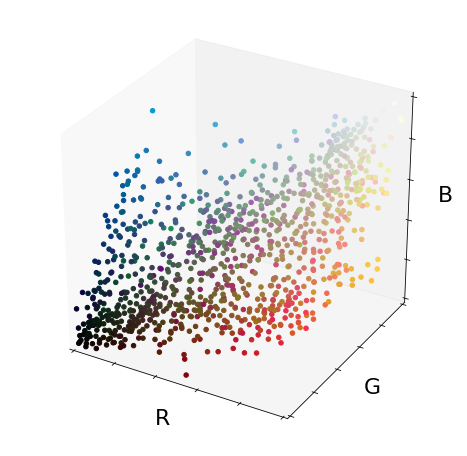

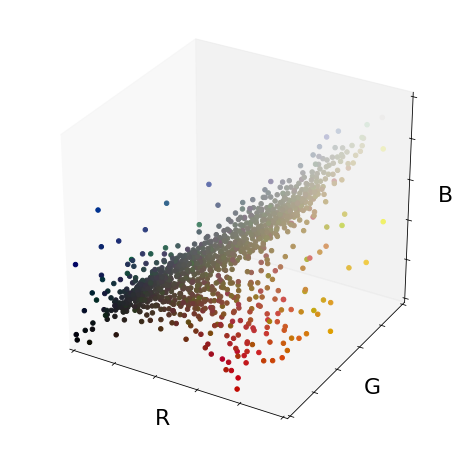

In [7]:
showImageAsPointCloud(Xs)
showImageAsPointCloud(Xt)

You can now compute the coupling between those two distributions using the exact LP solver (EMD)

In [8]:
import ot

mu_s = ot.unif(nbsamples)
mu_t = ot.unif(nbsamples)
M = ot.dist(Xs,Xt,"sqeuclidean")
G = ot.emd(mu_s,mu_t, M)

using the barycentric mapping method, express the tansformation of both images into the other one

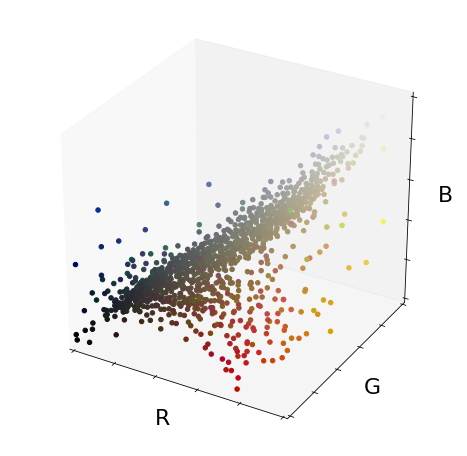

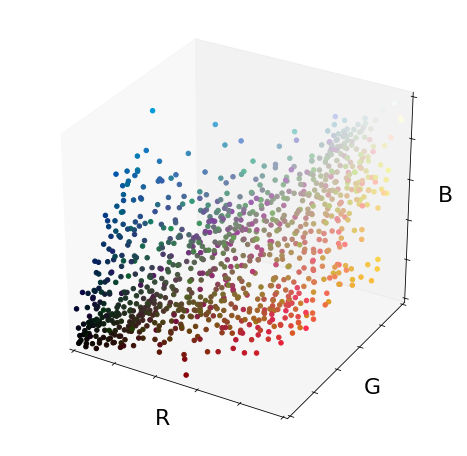

In [9]:
newXs=nbsamples*G.dot(Xt)
showImageAsPointCloud(newXs)

newXt=nbsamples*G.T.dot(Xs)
newXt[newXt>1]=1
showImageAsPointCloud(newXt)

Since only the centroid of clusters have changed, we need to figure out a simple way of transporting all the pixels in the original image. At first, we will apply a simple strategy where the new value of the pixel corresponds simply to the new position of its corresponding centroid

Express this transformation in your code, and display the corresponding adapted image.

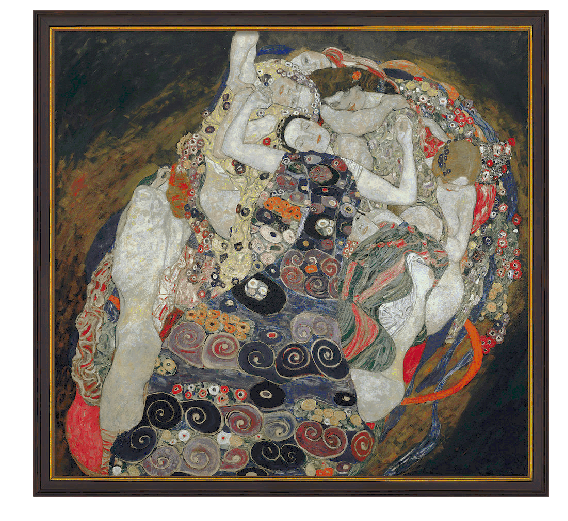

In [ ]:
newX1 = newXs[clust1.predict(X1),:]
showImage(mat2im(newX1,I1.shape))

newX2 = newXt[clust2.predict(X2),:]
showImage(mat2im(newX2,I2.shape))

You can use also the entropy regularized version of Optimal Transport (a.k.a. the Sinkhorn algorithm) to explore the impact of regularization on the final result


In [ ]:
for reg in np.logspace(-3,0,4):
    G = ot.bregman.sinkhorn(mu_s,mu_t, M, reg)
    newXs=nbsamples*G.dot(Xt)
    showImageAsPointCloud(newXs)
    newX1 = newXs[clust1.predict(X1),:]
    showImage(mat2im(newX1,I1.shape))